In [158]:
#!pip install openai
#!pip install google-cloud
from openai import OpenAI
import os
import urllib.request
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [146]:
#variables globales
standard_prompt_gpt = "Ponte en el papel de un ingeniero de prompts. Diseña un prompt conciso y resumido, con menos de 600 caracteres, que genere de una persona llevando a cabo una acción cotidiana. Asegúrate de detallar características biológicas realistas y un fondo apropiado. Evita que la persona mire directamente a la cámara. Asegúrate de ajustar las características biológicas de la persona y el fondo de la imagen para maximizar la fidelidad con la realidad. Utiliza las siguientes palabras clave: "
fenotipos = {
    "ascendencia" : ["europea", "africana", "asiática", "latina", "medio oriente"],
    "color_de_ojos" : ["marrones", "verdes", "azules", "negros", "grises", "avellana"],
    "color_de_pelo" : ["negro", "castaño oscuro", "castaño claro", "rubio oscuro", "rubio claro", "pelirrojo", "blanco", "gris"],
    "textura_del_cabello" : ["liso", "ondulado", "rizado", "muy rizado", "afro"],
    "estructura_facial" : ["ovalada", "redonda", "alargada", "cuadrada", "triangular"],
    "altura" : ["baja", "promedio", "alta", "muy alta"],
    "complexión" : ["delgada", "promedio", "robusta", "musculosa"],
    "forma_del_cuerpo" : ["ectomorfo", "mesomorfo", "endomorfo", "atlético", "curvilíneo"],
    "tamaño_de_labios" : ["delgados", "promedio", "carnosos", "muy carnosos"],
    "forma_de_la_nariz" : ["recta", "aguzada", "ancha", "puntiaguda", "nariz de silla"],
    "forma_de_la_mandíbula" : ["angular", "redonda", "cuadrada", "puntiaguda", "mandíbula prominente"],
    "lunares" : ["pocos", "algunos", "muchos", "muchísimos"],
    "vello_facial" : ["escaso", "normal", "denso", "barba completa", "barba escasa"],
    "vello_corporal" : ["escaso", "normal", "denso", "poco vello", "mucho vello"],
    "genero" : ["masculino", "femenino"]
}

# Short EDA - Exploratory Data Analysis

In [28]:
# Contar la cantidad de opciones en cada campo
for campo, opciones in fenotipos.items():
    cantidad_opciones = len(opciones)
    print(f"Campo: {campo}, Cantidad de opciones: {cantidad_opciones}")

Campo: ascendencia, Cantidad de opciones: 8
Campo: color_de_ojos, Cantidad de opciones: 6
Campo: color_de_pelo, Cantidad de opciones: 8
Campo: textura_del_cabello, Cantidad de opciones: 5
Campo: estructura_facial, Cantidad de opciones: 5
Campo: altura, Cantidad de opciones: 4
Campo: complexión, Cantidad de opciones: 4
Campo: edad, Cantidad de opciones: 6
Campo: forma_del_cuerpo, Cantidad de opciones: 5
Campo: tamaño_de_labios, Cantidad de opciones: 4
Campo: forma_de_la_nariz, Cantidad de opciones: 5
Campo: forma_de_la_mandíbula, Cantidad de opciones: 5
Campo: lunares, Cantidad de opciones: 4
Campo: vello_facial, Cantidad de opciones: 5
Campo: vello_corporal, Cantidad de opciones: 5


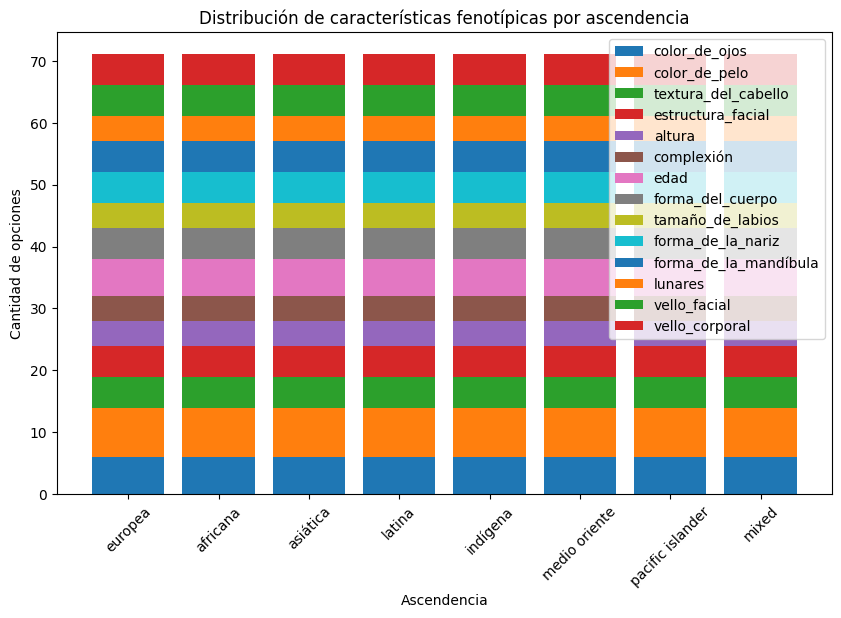

In [34]:
ascendencias = fenotipos["ascendencia"]
campos = list(fenotipos.keys())[1:] 

distribucion_ascendencia = np.zeros((len(ascendencias), len(campos)))

for i, ascendencia in enumerate(ascendencias):
    for j, campo in enumerate(campos):
        distribucion_ascendencia[i, j] = len(fenotipos[campo])

plt.figure(figsize=(10, 6))
plt.bar(ascendencias, distribucion_ascendencia[:, 0], label=campos[0])
for i in range(1, len(campos)):
    plt.bar(ascendencias, distribucion_ascendencia[:, i], bottom=np.sum(distribucion_ascendencia[:, :i], axis=1), label=campos[i])
plt.xlabel("Ascendencia")
plt.ylabel("Cantidad de opciones")
plt.title("Distribución de características fenotípicas por ascendencia")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Prompt - GPT 3.5. Turbo

In [4]:
#Obtener secret id de openai guardado en .txt
def obtainKey(path_s_key):
    try:
        with open(path_s_key, 'r') as file:
            key = file.read()
            return key
    except FileNotFoundError:
        print(f"The file '{path_s_key}' was not founded.")
    except Exception as e:
        print(f"Error: {e}")

In [5]:
#Instancia de openai con key asignado
api_key_ai=obtainKey('sec_key_opeain.txt')

client = OpenAI(
    api_key=api_key_ai,
)

In [68]:
#Funcion para llamar a chatgpt y que devuelva el prompt a pasar a dall-e
def call_gpt_api(prompt):
    try:
        chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="gpt-3.5-turbo",
        )
        choice=chat_completion.choices[0]
        message=choice.message
        response = message.content
        return response

    except Exception as e:
        print(f"ChatGPT: Ocurrió un error al comunicarse con la API de OpenAI: {e}")

# Generate Photo - Dall-E-3

In [100]:
def call_dalle_api(prompt_gpt):
    try:
        response = client.images.generate(
            prompt=prompt_gpt,
            model="dall-e-3",
            size="1024x1024",
            style="natural",
            quality="standard",
            n=1,
        )
        print('URL Generada correctamente desde DALL-E')
        return response.data[0].url

    except Exception as e:
        print(f"DALL-E: Ocurrió un error al comunicarse con la API de OpenAI: {e}") 

In [169]:
def download_photo(url): 
    try:
        rnd_id = random.randint(1, 50)
        urllib.request.urlretrieve(url, "../dataset/real-vs-fake/train/fake/AAAA_{}.png".format(rnd_id))
        absolute_path = os.path.abspath('../dataset/real-vs-fake/train/fake/AAAA_{}.png').format(rnd_id)
        print("Imagen descargada desde DALL-E correctamente")
        return absolute_path
    except Exception as e:
        print(f"Ha ocurrido un error al descargar el archivo: {str(e)}")

In [134]:
def get_prompt():
    prompt_form=prompt_to_gpt=''
    for t_fenotipo, v_fenotipo in fenotipos.items():
        rnd_fenotipo = random.choice(v_fenotipo)
        prompt_form += f"{t_fenotipo}: {rnd_fenotipo},"

    prompt_to_gpt = f"{standard_prompt_gpt}: {prompt_form}"
    return prompt_to_gpt


In [176]:
img_paths = []

for x in range(4):
    prompt_to_gpt=get_prompt()
    gpt_prompt=call_gpt_api(prompt_to_gpt)
    url=call_dalle_api(gpt_prompt)
    path=download_photo(url)
    img_paths.append(path)

URL Generada correctamente desde DALL-E
Imagen descargada desde DALL-E correctamente
URL Generada correctamente desde DALL-E
Imagen descargada desde DALL-E correctamente
URL Generada correctamente desde DALL-E
Imagen descargada desde DALL-E correctamente
URL Generada correctamente desde DALL-E
Imagen descargada desde DALL-E correctamente


In [183]:
def plot_images(img_list):
    num_images = len(img_list)
    plt.figure(figsize=[12, 12])
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.title("Created by Dall-E3")
        plt.imshow(img_list[i])
        plt.axis('off')

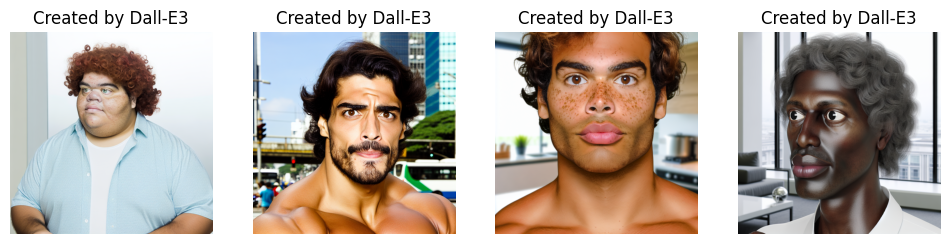

In [184]:
img_list = [Image.open(img_path) for img_path in img_paths]
plot_images(img_list)
plt.show()